## BloomTech Data Science

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [1]:
%%capture
!pip install category_encoders==2.*

In [3]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report # plot_confusion_matrix is deprecated
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [4]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contains the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [6]:
# List all files in your Kaggle folder on your google drive.
!ls

2025-08-08_2143_submission.csv	model_8043		 sample_submission.csv
2025-08-11_1658_submission.csv	model_rf_rs_80		 test_features.csv
dt_new_submission.csv		new_submission.csv	 train_features.csv
kaggle.json			rf_water_submission.csv  train_labels.csv


# I. Wrangle Data

In [19]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path,
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')

    # df['needs_repair'] = np.where(df['status_group']=='functional',0,1)
    # df.drop(columns='status_group', inplace=True)

  else:

    df = pd.read_csv(fm_path,
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')


  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns # check for atleast a 100 values
  dupe_cols = [col for col in df.head(100).T.duplicated().index
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)

  # need to check if status group actually exists in df or not (doesn't exist in test_features)
  if 'status_group' in df:
    df['needs_repair'] = np.where(df['status_group']=='functional',0,1)
    df.drop(columns='status_group', inplace=True)

  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

In [11]:
df.shape, X_test.shape

((47519, 32), (11880, 30))

## EDA


In [ ]:
# Classify into pumps that need repair and pumps that do not need repairs.
# functional - class 0 (negative class)
# non functional, functional needs repair - class 1 (positive class)

In [9]:
# OPTION 1
# df['needs_repair'] = np.where(df['status_group']=='functional',0,1) # returning a 0 if functional or a 1 if not functional

In [ ]:
# OPTION 2
# df['needs_repair'] = (df['status_group'] != 'functional').astype(int)

In [ ]:
# OPTION 3
# df['status_group'].apply(lambda x: 0 if x=='functional' else 1)

In [13]:
df['needs_repair'].unique()

array([0, 1])

# II. Split Data

In [20]:
# Split TV / FM
target = 'needs_repair'
X = df.drop(columns=target)
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [21]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


# Build Model


In [22]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=42) # default num of trees is 100
)

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, n_jobs=-1,
                                        random_state=42))])

# Interlude: Beware or Leakage

If you leave `'status_group'` in your feature matrix, you'll have **leakage**.

<Axes: >

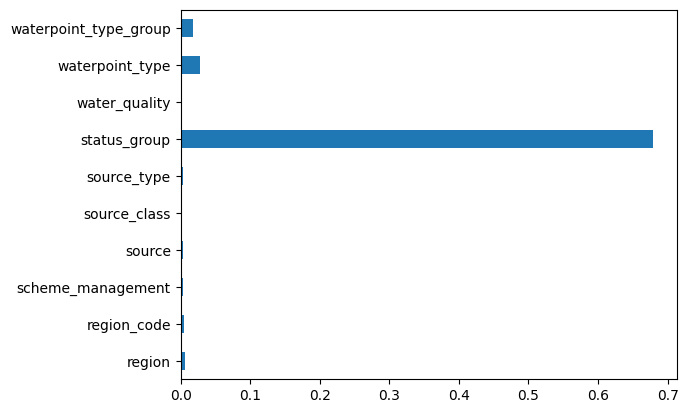

In [18]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_index().tail(10).plot(kind='barh') # status group is most important column. All other features have been reduced to zero. This is an example of data leakage. If you deploy this model in the real world, it will give you inaccurate predictions.

<Axes: >

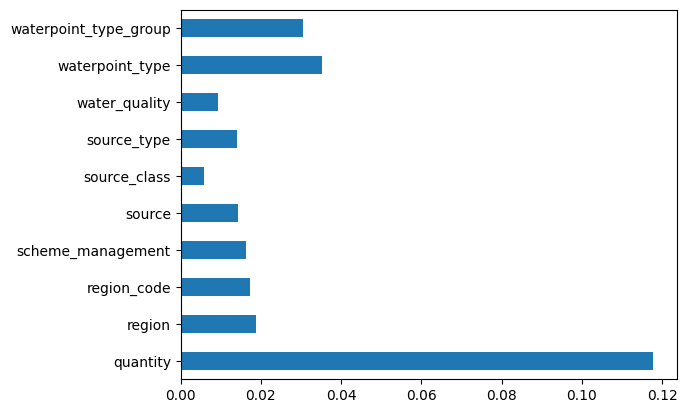

In [24]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_index().tail(10).plot(kind='barh')

# Check Metrics

**Pre-Dropping 'status_group' Accuracy Score**

In [17]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val)) # whenever you get a perfact accuracy, you have to be careful. Model has access to answers

Training Accuracy: 1.0
Validation Accuracy: 0.9997895622895623


**Post-Dropping 'status_group' accuracy score**

In [23]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993660397211627
Validation Accuracy: 0.8055555555555556


In [26]:
# predict spam
# total 10000 emails
# class 0 - 9900 - not spam
# class 1 - 100 - spam

accuracy = 9900/10000
accuracy

0.99

**Confusion Matrix**

A table that describes the performance of a classification model. Columns rep predicted class and rows represent true classes.

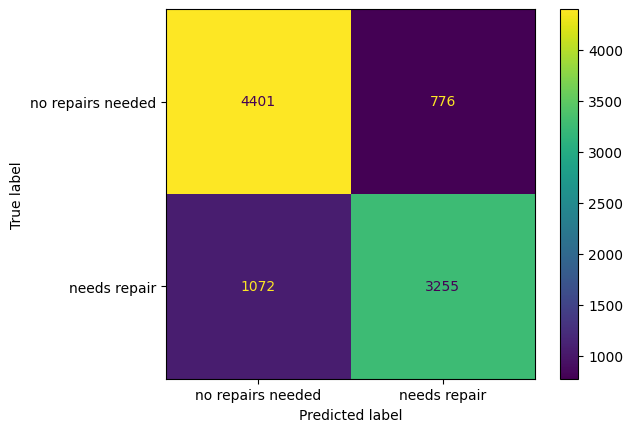

In [28]:
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator

plot_confusion_matrix(
  model,
  X_val,
  y_val,
  values_format='.0f',
  display_labels=['no repairs needed', 'needs repair']
)

accuracy = tn + tp / (tn + fp + fn + tp)

In [29]:
(4401 + 3255) / (4401 + 776 + 1072 + 3255)

0.8055555555555556

**Precision Score**

Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [ ]:
# precision = tp / (tp + fp)

In [30]:
3255 / (3255 + 776)

0.8074919374844952

**Recall Score**

Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [ ]:
# recall tp/(tp+fn)

In [31]:
3255 / (3255 + 1072)

0.7522532932747862

**Classification Report**

In [32]:
print(classification_report(y_val,
                      model.predict(X_val),
                      target_names=['no repairs needed', 'repairs needed']))

                   precision    recall  f1-score   support

no repairs needed       0.80      0.85      0.83      5177
   repairs needed       0.81      0.75      0.78      4327

         accuracy                           0.81      9504
        macro avg       0.81      0.80      0.80      9504
     weighted avg       0.81      0.81      0.80      9504



In [33]:
# F-score = 2 * (precision * recall) / precision + recall)

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections.

In [34]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [35]:
y_val.value_counts(normalize=True)

,proportion
needs_repair,
0,0.544718
1,0.455282


In [36]:
repair_prob = 0.455282

In [37]:

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', n_inspections * repair_prob)
print('Funds wasted:', int(n_inspections - n_inspections * repair_prob) * 100)

Inspections conducted: 2000
Pumps repaired: 910.5640000000001
Funds wasted: 108900


Scenario 2: Using our model "out of the box"

In [38]:
data = {
    'y_val':y_val,
    'y_pred':model.predict(X_val)
}

results = pd.DataFrame(data)

In [39]:
mask = (results['y_pred']==1)
sample = results[mask].sample(n_inspections)

In [40]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', int(n_inspections - sample['y_val'].sum()) * 100)

Inspections conducted: 2000
Pumps repaired: 1592
Funds wasted: 40800


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.85`) need repair.

In [41]:
data = {
    'y_val':y_val,
    'y_pred_proba':model.predict_proba(X_val)[:,-1]
}

results = pd.DataFrame(data)

In [42]:
threshold = 0.85

In [43]:
mask = (results['y_pred_proba'] > threshold)
sample = results[mask].sample(n_inspections)

In [44]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', int(n_inspections - sample['y_val'].sum()) * 100)


Inspections conducted: 2000
Pumps repaired: 1891
Funds wasted: 10900
